## 폐렴진단기 성능 개선 프로젝트

1. 개요

목표는 CNN 기반의 의료영상 처리 모델을 구축하고 성능을 개선하는 것.
다양한 실험(데이터 증강, 모델 구조 변경, ResNet-18 구현 등)을 통해 비교하고, 성능을 개선하는 것.

 <주요 목표>

  CNN 기반 베이스 모델 구현 및 학습 안정화
  데이터 증강(Data Augmentation) 기법 적용 후 성능 비교
  모델 구조 변경 및 ResNet-18 구현 후 성능 비교
  데이터 imblance 문제를 해결하기 위한 class weight 적용

2. 목차

  1.개요
  
  2.데이터 준비 및 전처리
  
  3.CNN 모델 구현 및 학습
  
  4.ResNet-18 모델 구현 및 학습
  
  5.성능 비교 및 결과 분석
  
  6.회고 및 개선점
  
  7.참고자료

In [5]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [15]:
#데이터전처리

In [18]:
import os
import random 
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")

In [19]:
# 데이터 로드 속도 향상을 위한 설정
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

In [20]:
# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/train/*/*')
VAL_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/val/*/*')
TEST_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/test/*/*')

In [21]:
#하이퍼 파라미터설정
BATCH_SIZE = 16
EPOCHS = 10

In [22]:
# 데이터 로드 및 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

In [23]:
print(f"Training samples: {len(train_filenames)}")
print(f"Validation samples: {len(val_filenames)}")
print(f"Test samples: {len(test_filenames)}")

Training samples: 5216
Validation samples: 16
Test samples: 624


In [24]:
# 데이터 전처리: 파일 경로에서 레이블 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.float32)  # 폐렴=1, 정상=0

In [25]:
# 이미지 디코딩 및 리사이즈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1] 범위로 정규화
    return img

In [26]:
# 파일 경로에서 이미지와 라벨 처리
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [27]:
# TensorFlow Dataset 구성
def prepare_dataset(filepaths):
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [28]:
train_ds = prepare_dataset(train_filenames)
val_ds = prepare_dataset(val_filenames)
test_ds = prepare_dataset(test_filenames)

In [29]:
# 데이터 imbalance 처리: class_weight 계산
count_normal = len([f for f in train_filenames if "NORMAL" in f])
count_pneumonia = len(train_filenames) - count_normal
weight_normal = 1 / count_normal * len(train_filenames) / 2.0
weight_pneumonia = 1 / count_pneumonia * len(train_filenames) / 2.0
class_weight = {0: weight_normal, 1: weight_pneumonia}

print(f"Weight for NORMAL: {weight_normal:.2f}")
print(f"Weight for PNEUMONIA: {weight_pneumonia:.2f}")

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [30]:
# **Step 1: CNN 모델 구현**
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [33]:
# **Step 2: ResNet-18 모델 구현**
def resnet_block(input_layer, filters, stride=1):
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Residual connection(skip connection)
    if stride != 1 or input_layer.shape[-1] != filters:
        input_layer = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_layer)
    x = layers.add([x, input_layer])
    return layers.Activation('relu')(x)

In [34]:
def build_resnet18():
    input_layer = layers.Input(shape=(180, 180, 3))
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = resnet_block(x, 64, stride=1)
    x = resnet_block(x, 64, stride=1)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128, stride=1)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256, stride=1)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(input_layer, output_layer)

resnet_model = build_resnet18()
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
# **모델 학습 및 성능 비교**
cnn_history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weight)
resnet_history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weight)

Epoch 1/10
326/326 [==============================] - 70s 33ms/step - loss: 27.1297 - accuracy: 0.9087 - val_loss: 1.0512 - val_accuracy: 0.6250
Epoch 2/10
326/326 [==============================] - 17s 33ms/step - loss: 0.1682 - accuracy: 0.9546 - val_loss: 0.9243 - val_accuracy: 0.6875
Epoch 3/10
326/326 [==============================] - 17s 33ms/step - loss: 0.2709 - accuracy: 0.9396 - val_loss: 1.3269 - val_accuracy: 0.5625
Epoch 4/10
326/326 [==============================] - 17s 33ms/step - loss: 1.5296 - accuracy: 0.9112 - val_loss: 0.9895 - val_accuracy: 0.6250
Epoch 5/10
326/326 [==============================] - 17s 33ms/step - loss: 0.3341 - accuracy: 0.9371 - val_loss: 1.0470 - val_accuracy: 0.6250
Epoch 6/10
326/326 [==============================] - 17s 33ms/step - loss: 0.3226 - accuracy: 0.9314 - val_loss: 0.6407 - val_accuracy: 0.8125
Epoch 7/10
326/326 [==============================] - 18s 33ms/step - loss: 0.3312 - accuracy: 0.9287 - val_loss: 1.0691 - val_accuracy

CNN 베이스 모델 학습 결과
Train Accuracy: 학습 데이터셋에 대해 꾸준히 90% 이상의 정확도를 유지, 마지막 에포크에서는 94.59%를 기록.
Validation Accuracy: 검증 데이터셋에 대해 초기에는 62.5%에서 시작, 마지막 에포크에서도 68.75% 수준으로 큰 개선은 없었음.
Train Loss: 학습 손실 값은 안정적으로 감소, 마지막 에포크에서 0.17 기록.
Validation Loss: 검증 손실 값은 초기에는 1.05에서 시작했으나 최종적으로 1.08로 다시 증가.

학습 데이터에서 매우 높은 정확도와 낮은 손실을 보이지만, 검증 데이터에서의 정확도와 손실이 개선되지 않는 점을 볼 때 과적합이 발생한 것으로 보임.
Validation Loss가 일정한 패턴 없이 증가하는 모습은 모델이 검증 데이터에 일반화되지 못한 것으로 보임.

ResNet-18 학습 결과
Train Accuracy: 학습 데이터셋에 대해 약 92_95% 수준의 정확도를 기록, CNN 모델과 비슷한 수준으로 학습.
Validation Accuracy: 검증 데이터셋에 대해 초기 50_62.5%를 기록, 이후 다시 50%로 감소하는 경향.
Train Loss: 학습 손실 값은 0.16까지 안정적으로 감소.
Validation Loss: 검증 손실 값은  5.88에서 시작하여 최종적으로 2.20으로 감소했지만, 여전히 높은 값을 유지함.

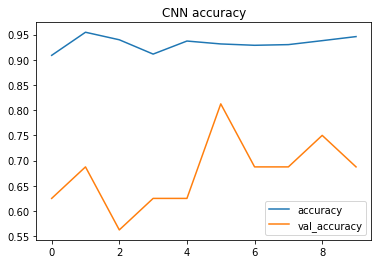

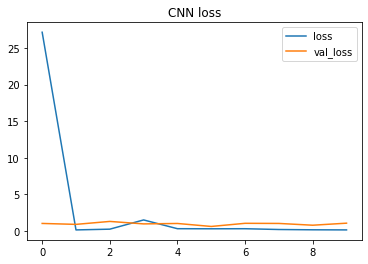

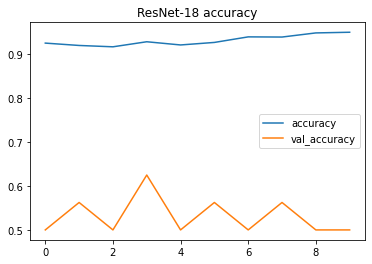

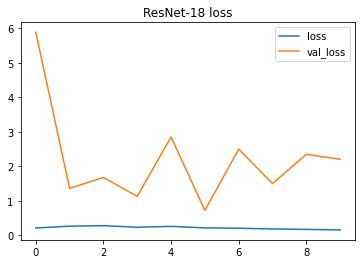

In [36]:
# **결과 시각화**
def plot_history(history, model_name):
    metrics = ['accuracy', 'loss']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(f'{model_name} {metric}')
        plt.legend()
        plt.show()

plot_history(cnn_history, "CNN")
plot_history(resnet_history, "ResNet-18")

In [37]:
# **Step 3: 테스트 데이터 평가**
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds)

print(f"CNN Test Accuracy: {cnn_acc:.4f}")
print(f"ResNet Test Accuracy: {resnet_acc:.4f}")

39/39 [==============================] - 2s 15ms/step - loss: 1.5792 - accuracy: 0.6266
CNN Test Accuracy: 0.6747
ResNet Test Accuracy: 0.6266
